# compare the results obtained from the grid search 

In [1]:
# imports 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
os.chdir('/home/grig0076/GitHubs/Phynteny_transformer/')
from src import model_onehot
import torch
import umap
import matplotlib.pyplot as plt
import numpy as np 
import torch.nn.functional as F

/home/grig0076/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
# read in validation loss etc. 

metrics = pd.read_csv('/home/grig0076/GitHubs/Phynteny_transformer_15012025/Phynteny_transformer/17012025_inphared_avlogpenalty_lambda100_randomintialised_4heads_lr4_16batch_10epochs/fold_1/metrics.csv')

In [26]:
metrics['diagonal_penalities'] = np.log10(metrics['diagonal_penalities'])

<Axes: xlabel='epoch', ylabel='training losses'>

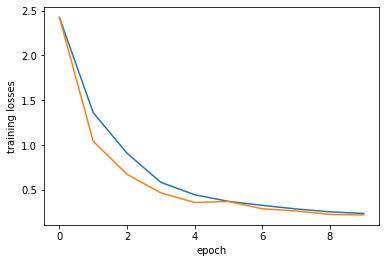

In [23]:
# see if amount masks influences the way that the model trains 
sns.lineplot(data=metrics, x = 'epoch', y = 'training losses') 
sns.lineplot(data=metrics, x = 'epoch', y = 'validation losses') 

<Axes: xlabel='epoch', ylabel='diagonal_penalities'>

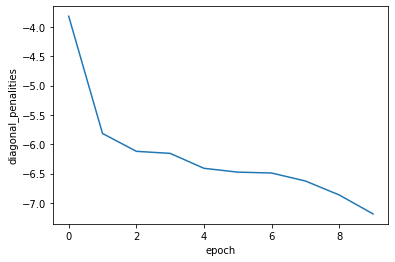

In [27]:
sns.lineplot(data=metrics, x = 'epoch', y = 'diagonal_penalities') # plotting the log of the diagonal penalties is probably the right approach to use here 

In [2]:
# plot the loss and validation loss across 10 different kfolds

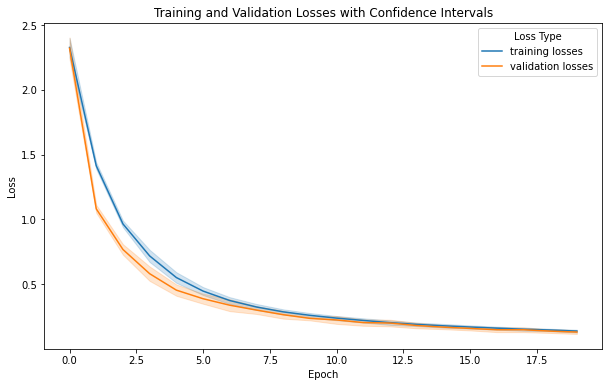

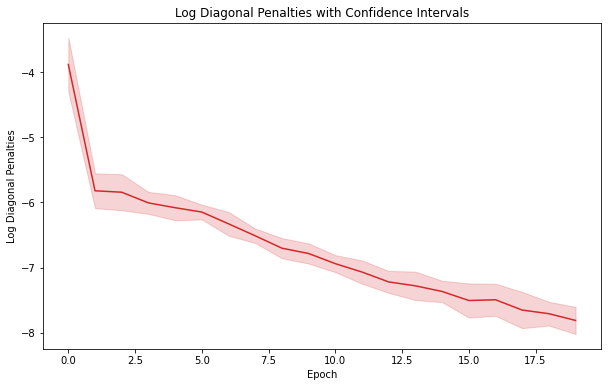

In [30]:
# Combine metrics from all folds into a single DataFrame
all_metrics = []

for k in range(10):
    fold_path = os.path.join(model_path, f'fold_{k+1}', 'metrics.csv')
    metrics = pd.read_csv(fold_path)
    metrics['log_diagonal_penalties'] = np.log10(metrics['diagonal_penalities'])
    metrics['fold'] = f'Fold {k+1}'
    all_metrics.append(metrics)

# Concatenate all metrics into a single DataFrame
all_metrics_df = pd.concat(all_metrics, ignore_index=True)

# Melt the DataFrame for easier plotting
losses_melted = all_metrics_df.melt(
    id_vars=['epoch', 'fold'],
    value_vars=['training losses', 'validation losses'],
    var_name='Loss Type',
    value_name='Loss'
)

# Plot combined training and validation losses with mean and confidence interval
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=losses_melted,
    x='epoch',
    y='Loss',
    hue='Loss Type',
    errorbar='sd',
    palette='tab10'
)
plt.title('Training and Validation Losses with Confidence Intervals')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(title='Loss Type')
plt.show()

# Plot log-diagonal penalties with mean and confidence interval
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=all_metrics_df,
    x='epoch',
    y='log_diagonal_penalties',
    errorbar='sd',
    color='tab:red'
)
plt.title('Log Diagonal Penalties with Confidence Intervals')
plt.ylabel('Log Diagonal Penalties')
plt.xlabel('Epoch')
plt.show()

## Code for making predictions, ROC curves and computing metrics 

In [210]:
# read in the validation data 
val_data = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer_15012025/Phynteny_transformer/_17012025_saveidx_inphared_avlogpenalty_lambda100_randomintialised_4heads_lr4_16batch_10epochs_allfolds/fold_3/val_kfold_loader.pkl','rb'))

# read in the model 
m = model_onehot.Seq2SeqTransformerClassifierRelativeAttention(input_dim=1293, num_classes=9, num_heads=4, hidden_dim=512, dropout=0.1)
# THIS MODEL IS NOT CORRECT ONE - SWAP IT OUT
m.load_state_dict(torch.load('/home/grig0076/GitHubs/Phynteny_transformer_15012025/Phynteny_transformer/_17012025_saveidx_inphared_avlogpenalty_lambda100_randomintialised_4heads_lr4_16batch_10epochs_allfolds/fold_3transformer.model',  map_location=torch.device('cpu')))               
m.eval()

device='cpu'

In [31]:
for k in range(10): 

    # read in the validation data 
    val_data = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer_15012025/Phynteny_transformer/_17012025_saveidx_inphared_avlogpenalty_lambda100_randomintialised_4heads_lr4_16batch_10epochs_allfolds/fold_' + str(k+1) + '/val_kfold_loader.pkl','rb'))

    # read in the model 
    m = model_onehot.Seq2SeqTransformerClassifierRelativeAttention(input_dim=1293, num_classes=9, num_heads=4, hidden_dim=512, dropout=0.1)
    m.load_state_dict(torch.load('/home/grig0076/GitHubs/Phynteny_transformer_15012025/Phynteny_transformer/_17012025_saveidx_inphared_avlogpenalty_lambda100_randomintialised_4heads_lr4_16batch_10epochs_allfolds/fold_' + str(k+1) + 'transformer.model',  map_location=torch.device('cpu')))               
    m.eval()

    device='cpu'

Some testing code to understand how it all goes together 

### Make a ROC curve for a single training fold

In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

In [ ]:
# read in the cateogries 
phrog_categories = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer/phynteny_utils/integer_category.pkl', 'rb'))
phrog_categories = dict(zip([k -1 for k in list(phrog_categories.keys())], list(phrog_categories.values())))

Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...


<ipython-input-36-70bea663b817>:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


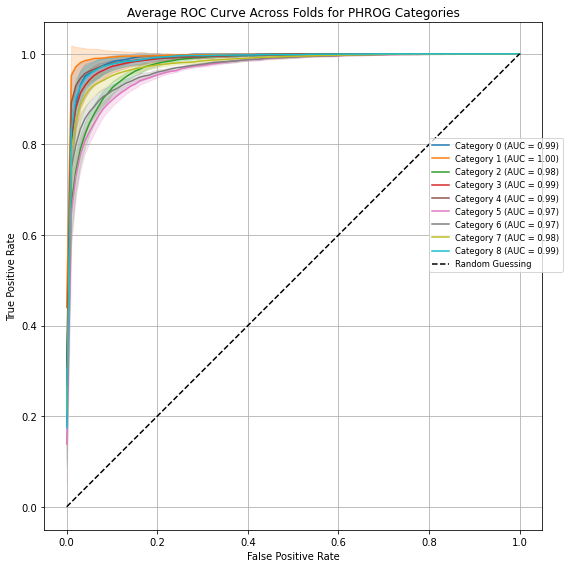

In [36]:
# Parameters
num_classes = 9
device = 'cpu'
phrog_categories = [f"Category {i}" for i in range(num_classes)]  # Replace with actual category names

# Initialize accumulators for ROC data across folds
fpr_dict = {i: [] for i in range(num_classes)}
tpr_dict = {i: [] for i in range(num_classes)}
roc_auc_dict = {i: [] for i in range(num_classes)}

# Loop through the 10 folds
for k in range(10):
    print(f"Processing fold {k+1}...")

    # Load validation data and model
    val_data = pickle.load(open(
        f'/home/grig0076/GitHubs/Phynteny_transformer_15012025/Phynteny_transformer/_17012025_saveidx_inphared_avlogpenalty_lambda100_randomintialised_4heads_lr4_16batch_10epochs_allfolds/fold_{k+1}/val_kfold_loader.pkl', 'rb'
    ))
    m = model_onehot.Seq2SeqTransformerClassifierRelativeAttention(input_dim=1293, num_classes=num_classes, num_heads=4, hidden_dim=512, dropout=0.1)
    m.load_state_dict(torch.load(
        f'/home/grig0076/GitHubs/Phynteny_transformer_15012025/Phynteny_transformer/_17012025_saveidx_inphared_avlogpenalty_lambda100_randomintialised_4heads_lr4_16batch_10epochs_allfolds/fold_{k+1}transformer.model',
        map_location=torch.device('cpu')
    ))
    m.eval()

    # Accumulators for fold
    all_probs = []
    all_categories = []

    # Process batches
    for embeddings, categories, masks, idx in val_data:
        batch_size = embeddings.shape[0]
        embeddings, categories, masks = (
            embeddings.to(device).float(),
            categories.to(device).long(),
            masks.to(device).float(),
        )
        src_key_padding_mask = (masks != -2)  # Mask for non-padding elements
        outputs = m(embeddings, src_key_padding_mask=src_key_padding_mask.to(device))  # Model prediction
        probs = F.softmax(outputs, dim=2)  # Apply softmax to get probabilities

        # Collect probabilities and true labels
        for i in range(batch_size):
            all_probs.extend(probs[i][idx[i]].tolist())
            all_categories.extend(categories[i][idx[i]].tolist())

    # Convert to numpy arrays
    all_probs = np.array(all_probs)
    all_categories = np.array(all_categories)

    # One-hot encode ground truth categories
    y_true = label_binarize(all_categories, classes=np.arange(num_classes))

    # Compute ROC data for each category
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        fpr_dict[i].append(np.interp(np.linspace(0, 1, 100), fpr, tpr))  # Interpolate TPRs to fixed FPRs
        tpr_dict[i].append(tpr)
        roc_auc_dict[i].append(roc_auc)

# Average ROC curves and AUCs across folds
mean_fpr = np.linspace(0, 1, 100)
mean_tpr_dict = {}
mean_auc_dict = {}

for i in range(num_classes):
    mean_tpr_dict[i] = np.mean(fpr_dict[i], axis=0)
    std_tpr = np.std(fpr_dict[i], axis=0)
    mean_auc_dict[i] = np.mean(roc_auc_dict[i])

# Plot average ROC curves with confidence intervals
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', num_classes)

for i in range(num_classes):
    label = f"{phrog_categories[i]} (AUC = {mean_auc_dict[i]:.2f})"
    plt.plot(mean_fpr, mean_tpr_dict[i], label=label, color=colors(i))
    plt.fill_between(mean_fpr,
                     mean_tpr_dict[i] - std_tpr,
                     mean_tpr_dict[i] + std_tpr,
                     alpha=0.2,
                     color=colors(i))

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")

# Set square aspect ratio
plt.gca().set_aspect("equal", adjustable="box")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curve Across Folds for PHROG Categories")
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 0.5), fontsize="small")
plt.grid()
plt.tight_layout()
plt.show()

100


<ipython-input-228-f60569f8b277>:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


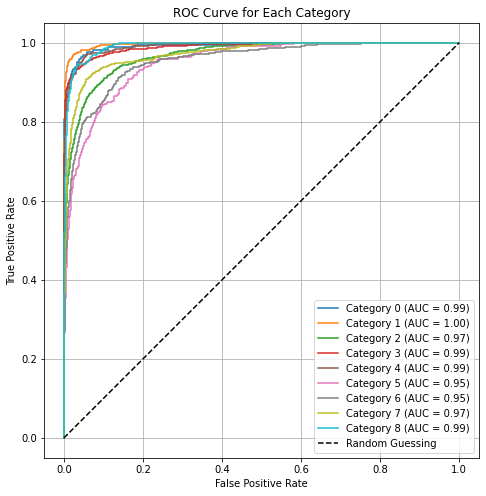

In [228]:
# Initialize accumulators for all batches
all_probs = []  # To store probability vectors for all sequences
all_categories = []  # To store ground truth labels

batches = 0 

# Loop through validation data
for embeddings, categories, masks, idx in val_data:
    batch_size = embeddings.shape[0]
    embeddings, categories, masks = (
        embeddings.to(device).float(),
        categories.to(device).long(),
        masks.to(device).float(),
    )
    src_key_padding_mask = (masks != -2)  # Masking for non-padding elements
    outputs = m(embeddings, src_key_padding_mask=src_key_padding_mask.to(device))  # Model prediction
    
    # Apply softmax to get probabilities
    probs = F.softmax(outputs, dim=2)
    
    # Collect masked outputs
    for i in range(batch_size):
        all_probs.extend(probs[i][idx[i]].tolist())  # Save the full probability vector
        all_categories.extend(categories[i][idx[i]].tolist())  # Save ground truth labels
        
    batches+=1 
    if batches % 100 ==0: 
        print(batches)

# Convert to numpy arrays for processing
all_probs = np.array(all_probs)  # Shape: (num_samples, num_classes)
all_categories = np.array(all_categories)  # Shape: (num_samples,)

# One-hot encode ground truth categories
num_classes = 9  # Update if you have more/less classes
y_true = label_binarize(all_categories, classes=np.arange(num_classes))

# Compute ROC curve and AUC for each category
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for all categories
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', num_classes)

for i in range(num_classes):
    label = f"{phrog_categories[i]} (AUC = {roc_auc[i]:.2f})"
    plt.plot(
        fpr[i],
        tpr[i],
        label=label,
        color=colors(i),
    )

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")

# Set square aspect ratio
plt.gca().set_aspect("equal", adjustable="box")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for PHROG Categories")
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 0.5), fontsize="small")
plt.grid()
plt.tight_layout()
plt.show()

Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...


<ipython-input-38-92218eef747e>:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


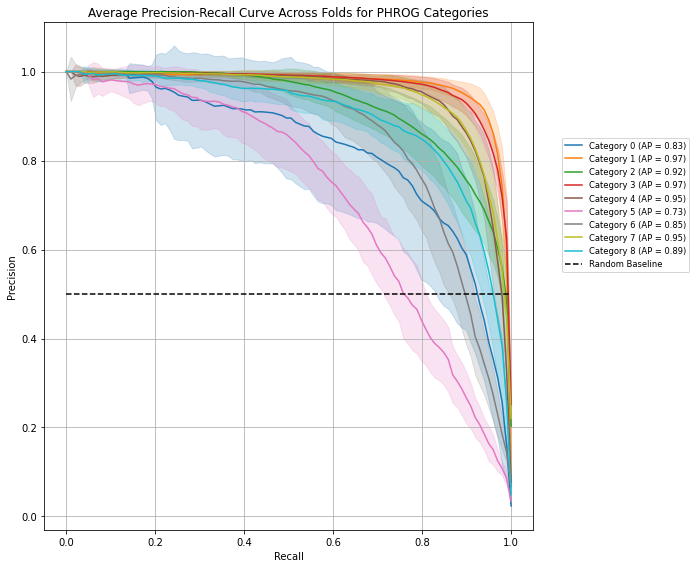

In [38]:
# Parameters
num_classes = 9
device = 'cpu'
phrog_categories = [f"Category {i}" for i in range(num_classes)]  # Replace with actual category names

# Initialize accumulators for PR data across folds
precision_dict = {i: [] for i in range(num_classes)}
recall_dict = {i: [] for i in range(num_classes)}
average_precision_dict = {i: [] for i in range(num_classes)}

# Loop through the 10 folds
for k in range(10):
    print(f"Processing fold {k+1}...")

    # Load validation data and model
    val_data = pickle.load(open(
        f'/home/grig0076/GitHubs/Phynteny_transformer_15012025/Phynteny_transformer/_17012025_saveidx_inphared_avlogpenalty_lambda100_randomintialised_4heads_lr4_16batch_10epochs_allfolds/fold_{k+1}/val_kfold_loader.pkl', 'rb'
    ))
    m = model_onehot.Seq2SeqTransformerClassifierRelativeAttention(input_dim=1293, num_classes=num_classes, num_heads=4, hidden_dim=512, dropout=0.1)
    m.load_state_dict(torch.load(
        f'/home/grig0076/GitHubs/Phynteny_transformer_15012025/Phynteny_transformer/_17012025_saveidx_inphared_avlogpenalty_lambda100_randomintialised_4heads_lr4_16batch_10epochs_allfolds/fold_{k+1}transformer.model',
        map_location=torch.device('cpu')
    ))
    m.eval()

    # Accumulators for fold
    all_probs = []
    all_categories = []

    # Process batches
    for embeddings, categories, masks, idx in val_data:
        batch_size = embeddings.shape[0]
        embeddings, categories, masks = (
            embeddings.to(device).float(),
            categories.to(device).long(),
            masks.to(device).float(),
        )
        src_key_padding_mask = (masks != -2)  # Mask for non-padding elements
        outputs = m(embeddings, src_key_padding_mask=src_key_padding_mask.to(device))  # Model prediction
        probs = F.softmax(outputs, dim=2)  # Apply softmax to get probabilities

        # Collect probabilities and true labels
        for i in range(batch_size):
            all_probs.extend(probs[i][idx[i]].tolist())
            all_categories.extend(categories[i][idx[i]].tolist())

    # Convert to numpy arrays
    all_probs = np.array(all_probs)
    all_categories = np.array(all_categories)

    # One-hot encode ground truth categories
    y_true = label_binarize(all_categories, classes=np.arange(num_classes))

    # Compute PR data for each category
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], all_probs[:, i])
        avg_precision = average_precision_score(y_true[:, i], all_probs[:, i])
        precision_dict[i].append(np.interp(np.linspace(0, 1, 100), recall[::-1], precision[::-1]))  # Interpolated Precision
        recall_dict[i].append(np.linspace(0, 1, 100))  # Standard Recall
        average_precision_dict[i].append(avg_precision)

# Average PR curves and APs across folds
mean_precision_dict = {}
mean_ap_dict = {}
std_precision_dict = {}

for i in range(num_classes):
    mean_precision_dict[i] = np.mean(precision_dict[i], axis=0)
    std_precision_dict[i] = np.std(precision_dict[i], axis=0)
    mean_ap_dict[i] = np.mean(average_precision_dict[i])

# Plot average PR curves with confidence intervals
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', num_classes)

for i in range(num_classes):
    label = f"{phrog_categories[i]} (AP = {mean_ap_dict[i]:.2f})"
    plt.plot(np.linspace(0, 1, 100), mean_precision_dict[i], label=label, color=colors(i))
    plt.fill_between(
        np.linspace(0, 1, 100),
        mean_precision_dict[i] - std_precision_dict[i],
        mean_precision_dict[i] + std_precision_dict[i],
        alpha=0.2,
        color=colors(i),
    )

# Plot random baseline
plt.plot([0, 1], [0.5, 0.5], "k--", label="Random Baseline")

# Set square aspect ratio
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Average Precision-Recall Curve Across Folds for PHROG Categories")
plt.legend(loc="lower left", bbox_to_anchor=(1.05, 0.5), fontsize="small")
plt.grid()
plt.tight_layout()
plt.show()


100


<ipython-input-229-1271f039b64b>:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


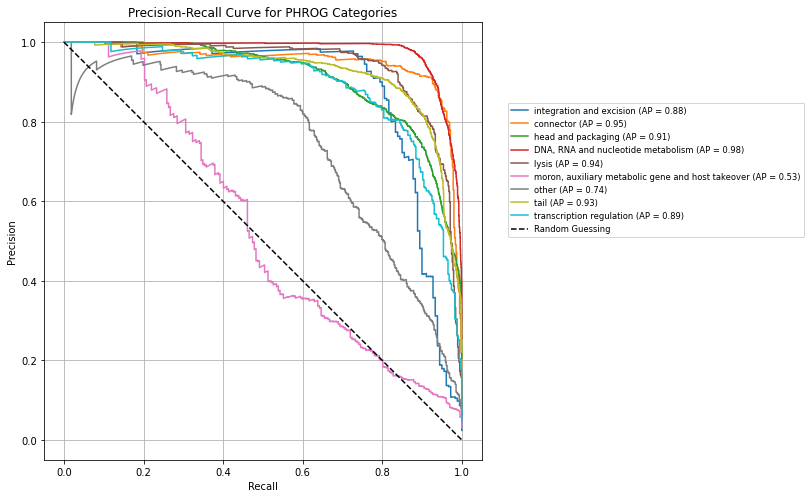

In [229]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Initialize accumulators for all batches
all_probs = []  # To store probability vectors for all sequences
all_categories = []  # To store ground truth labels

batches = 0

# Loop through validation data
for embeddings, categories, masks, idx in val_data:
    batch_size = embeddings.shape[0]
    embeddings, categories, masks = (
        embeddings.to(device).float(),
        categories.to(device).long(),
        masks.to(device).float(),
    )
    src_key_padding_mask = (masks != -2)  # Masking for non-padding elements
    outputs = m(embeddings, src_key_padding_mask=src_key_padding_mask.to(device))  # Model prediction
    
    # Apply softmax to get probabilities
    probs = F.softmax(outputs, dim=2)
    
    # Collect masked outputs
    for i in range(batch_size):
        all_probs.extend(probs[i][idx[i]].tolist())  # Save the full probability vector
        all_categories.extend(categories[i][idx[i]].tolist())  # Save ground truth labels
        
    batches += 1
    if batches % 100 == 0:
        print(batches)

# Convert to numpy arrays for processing
all_probs = np.array(all_probs)  # Shape: (num_samples, num_classes)
all_categories = np.array(all_categories)  # Shape: (num_samples,)

# One-hot encode ground truth categories
num_classes = 9  # Update if you have more/less classes
y_true = label_binarize(all_categories, classes=np.arange(num_classes))

# Compute PR curve and Average Precision (AP) for each category
precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], all_probs[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], all_probs[:, i])

# Plot PR curves for all categories
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', num_classes)

for i in range(num_classes):
    label = f"{phrog_categories[i]} (AP = {average_precision[i]:.2f})"
    plt.plot(
        recall[i],
        precision[i],
        label=label,
        color=colors(i),
    )

# Plot random baseline
# Set square aspect ratio
plt.gca().set_aspect("equal", adjustable="box")
plt.plot([0, 1], [1, 0], "k--", label="Random Guessing")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for PHROG Categories")
plt.legend(loc="lower left", bbox_to_anchor=(1.05, 0.5), fontsize="small")
plt.grid()
plt.tight_layout()
plt.show()


The precision recall curve is good because it shows better separation. The fact that it is not as good means that there might be issues with class imbalance. Will need to take a look into this. 

### Incorporate results across 10 different folds 

# Metrics of F1 score, precision, recall etc. 

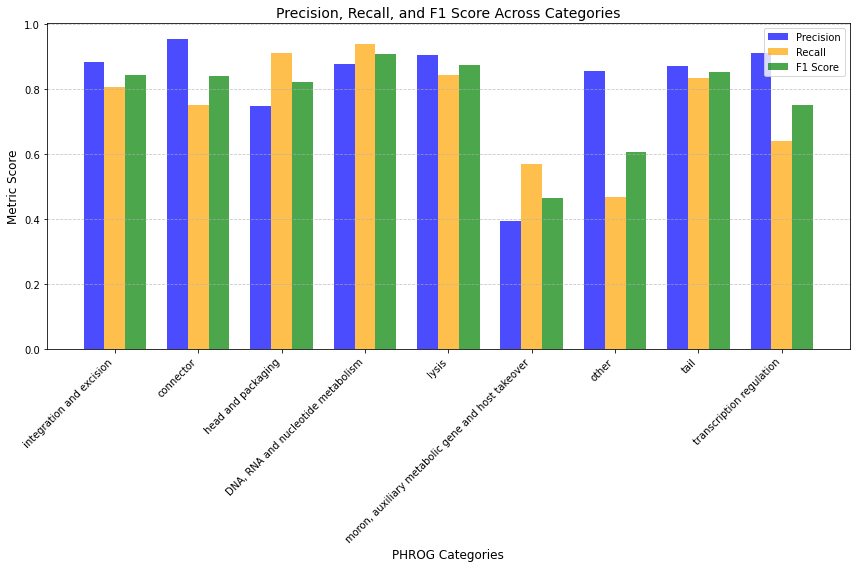

In [231]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_probs and all_categories are populated
all_probs = np.array(all_probs)  # Shape: (num_samples, num_classes)
all_categories = np.array(all_categories)  # Shape: (num_samples,)

# Get predicted categories
predicted_categories = np.argmax(all_probs, axis=1)

# Compute metrics
num_classes = 9  # Adjust based on your data
precision = precision_score(all_categories, predicted_categories, average=None, labels=np.arange(num_classes))
recall = recall_score(all_categories, predicted_categories, average=None, labels=np.arange(num_classes))
f1 = f1_score(all_categories, predicted_categories, average=None, labels=np.arange(num_classes))

# PHROG category labels
phrog_categories = {
    3: 'DNA, RNA and nucleotide metabolism',
    1: 'connector',
    2: 'head and packaging',
    0: 'integration and excision',
    4: 'lysis',
    5: 'moron, auxiliary metabolic gene and host takeover',
    6: 'other',
    7: 'tail',
    8: 'transcription regulation'
}
category_labels = [phrog_categories[i] for i in range(num_classes)]

# Plot metrics
x = np.arange(num_classes)  # Category indices
width = 0.25  # Bar width

plt.figure(figsize=(12, 8))
plt.bar(x - width, precision, width, label='Precision', color='blue', alpha=0.7)
plt.bar(x, recall, width, label='Recall', color='orange', alpha=0.7)
plt.bar(x + width, f1, width, label='F1 Score', color='green', alpha=0.7)

# Add labels and titles
plt.xticks(x, category_labels, rotation=45, ha='right', fontsize=10)
plt.xlabel("PHROG Categories", fontsize=12)
plt.ylabel("Metric Score", fontsize=12)
plt.title("Precision, Recall, and F1 Score Across Categories", fontsize=14)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [237]:
from collections import Counter
Counter(all_categories)

Counter({3: 1903,
         4: 587,
         7: 1653,
         1: 559,
         5: 232,
         2: 1532,
         8: 347,
         0: 180,
         6: 488})

## Make a confusion matrix showing the results 

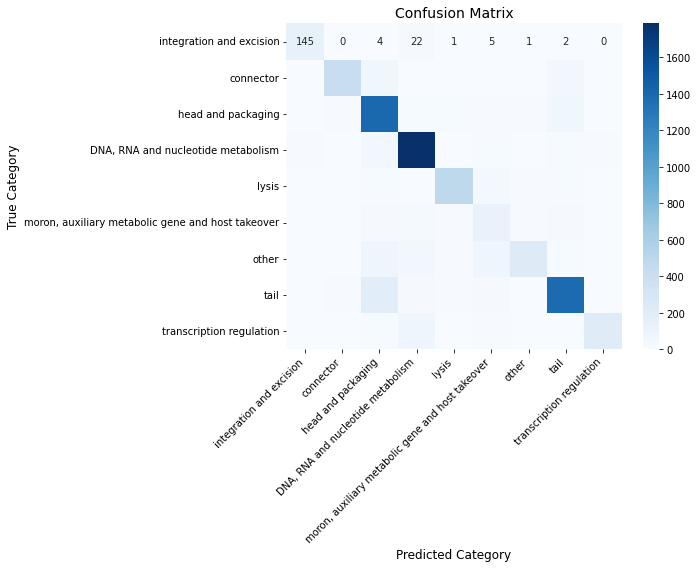

In [233]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming all_probs and all_categories are populated
all_probs = np.array(all_probs)  # Shape: (num_samples, num_classes)
all_categories = np.array(all_categories)  # Shape: (num_samples,)

# Get predicted categories
predicted_categories = np.argmax(all_probs, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(all_categories, predicted_categories, labels=np.arange(num_classes))

# PHROG category labels
phrog_categories = {
    3: 'DNA, RNA and nucleotide metabolism',
    1: 'connector',
    2: 'head and packaging',
    0: 'integration and excision',
    4: 'lysis',
    5: 'moron, auxiliary metabolic gene and host takeover',
    6: 'other',
    7: 'tail',
    8: 'transcription regulation'
}
category_labels = [phrog_categories[i] for i in range(num_classes)]

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_labels, yticklabels=category_labels)

# Add labels and title
plt.xlabel("Predicted Category", fontsize=12)
plt.ylabel("True Category", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


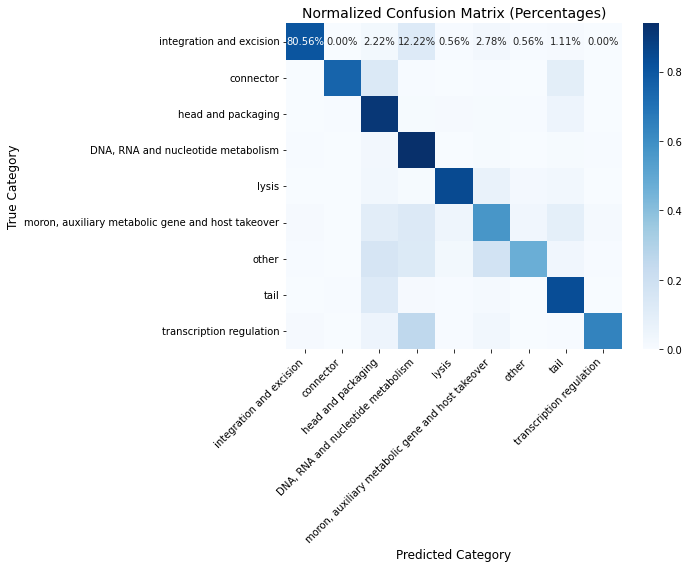

In [234]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming all_probs and all_categories are populated
all_probs = np.array(all_probs)  # Shape: (num_samples, num_classes)
all_categories = np.array(all_categories)  # Shape: (num_samples,)

# Get predicted categories
predicted_categories = np.argmax(all_probs, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(all_categories, predicted_categories, labels=np.arange(num_classes))

# Normalize confusion matrix by true category totals (rows)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# PHROG category labels
phrog_categories = {
    3: 'DNA, RNA and nucleotide metabolism',
    1: 'connector',
    2: 'head and packaging',
    0: 'integration and excision',
    4: 'lysis',
    5: 'moron, auxiliary metabolic gene and host takeover',
    6: 'other',
    7: 'tail',
    8: 'transcription regulation'
}
category_labels = [phrog_categories[i] for i in range(num_classes)]

# Plot normalized confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2%", cmap='Blues', xticklabels=category_labels, yticklabels=category_labels)

# Add labels and title
plt.xlabel("Predicted Category", fontsize=12)
plt.ylabel("True Category", fontsize=12)
plt.title("Normalized Confusion Matrix (Percentages)", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


# Show the esm embeddings used 
Embeddings might also work well for making predictions outside of the testing - i.e with phold

In [159]:
print(predicted[0][idx[0]])
print(categories[0][idx[0]]) 
print(max_probs[0][idx[0]])

tensor([3, 2, 1, 3, 3, 3])
tensor([3, 2, 1, 3, 3, 3])
tensor([0.9999, 0.9997, 1.0000, 0.9991, 0.9997, 0.9997],
       grad_fn=<IndexBackward>)


In [157]:
max_probs[0][idx[0]]

tensor([0.9999, 0.9997, 1.0000, 0.9991, 0.9997, 0.9997],
       grad_fn=<IndexBackward>)

In [154]:
categories[0][idx[0]]

tensor([3, 2, 1, 3, 3, 3])

In [115]:
# use the mask to get the idx 
masks = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer_15012025/Phynteny_transformer/17012025_inphared_avlogpenalty_lambda100_randomintialised_4heads_lr4_16batch_10epochs_allfolds/fold_1/final_validation_masks.pkl', 'rb'))

In [120]:
masks[0][0]

array([ 0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,
        1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,
        1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2.], dtype=float32)

# Make a figure to show the attention weights 

In [136]:
y = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer/notebooks/January2024/merged_data.y.pkl', 'rb'))

In [5]:
weights = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer/notebooks/January2024/64_0.1_circular_1e-4_0.05_256_4_2_0.1_5/final_validation_weights.pkl', 'rb'))
categories = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer/notebooks/January2024/64_0.1_circular_1e-4_0.05_256_4_2_0.1_5/final_validation_categories.pkl', 'rb'))

In [52]:
attn = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer/notebooks/January2024/64_0.1_circular_1e-4_0.05_256_4_2_0.1_5/final_validation_attention.pkl', 'rb'))
categories = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer/notebooks/January2024/64_0.1_circular_1e-4_0.05_256_4_2_0.1_5/final_validation_categories.pkl', 'rb'))

In [12]:
#attn = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer_15012025/Phynteny_transformer/PhageScope_circular_diagonalloss_randomintialised_4heads_lr4_short_16batch/fold_1/final_validation_attention.pkl', 'rb'))
#categories = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer_15012025/Phynteny_transformer/PhageScope_circular_diagonalloss_randomintialised_4heads_lr4_short_16batch/fold_1/final_validation_categories.pkl', 'rb'))

<Axes: >

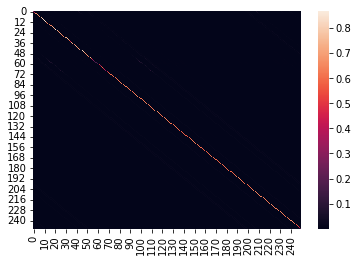

# See what happens with inphared data on pawsey

In [41]:
attn = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer/notebooks/January2024/pawsey_inphared_16012025/final_validation_attention.pkl', 'rb'))
categories = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer/notebooks/January2024/pawsey_inphared_16012025/final_validation_categories.pkl', 'rb'))
masks = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer/notebooks/January2024/pawsey_inphared_16012025/final_validation_masks.pkl', 'rb'))

In [46]:
len(masks)

127

In [51]:
masks[0][0] # model should be ignoring the last part that is masked out, not taking it in 

# next repeat with batch size of 16 

array([ 1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
        1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
        0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.],
      dtype=float32)

<Axes: >

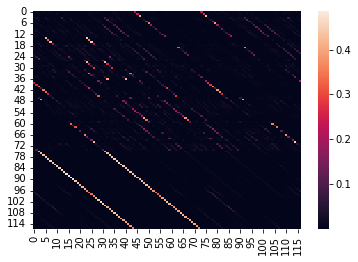

In [35]:
sns.heatmap(attn[0][0][0]) # seems to be learning fine

seems to learn correctly 

## Compare with a single phageScope chunk trained on Pawsey

In [28]:
#attn = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer/notebooks/January2024/pawsey_PhageScopechunk_16012025/final_validation_attention.pkl', 'rb'))
#categories = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer/notebooks/January2024/pawsey_PhageScopechunk_16012025/final_validation_categories.pkl', 'rb'))
#masks = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer/notebooks/January2024/pawsey_PhageScopechunk_16012025/final_validation_masks.pkl', 'rb'))


## Trying to figure out what parts of the sequences the model is 'attending' to 

In [30]:
# remake for different array - where the masking length occurs 
attn = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer_15012025/Phynteny_transformer/17012025_inphared_avlogpenalty_lambda100_randomintialised_4heads_lr4_16batch_10epochs/fold_1/final_validation_attention.pkl', 'rb'))
categories = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer_15012025/Phynteny_transformer/17012025_inphared_avlogpenalty_lambda100_randomintialised_4heads_lr4_16batch_10epochs/fold_1/final_validation_categories.pkl', 'rb'))
masks = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer_15012025/Phynteny_transformer/17012025_inphared_avlogpenalty_lambda100_randomintialised_4heads_lr4_16batch_10epochs/fold_1/final_validation_masks.pkl', 'rb'))

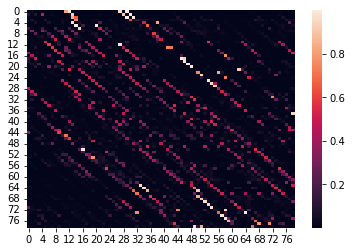

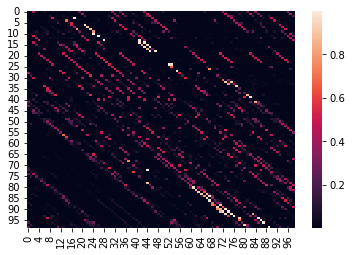

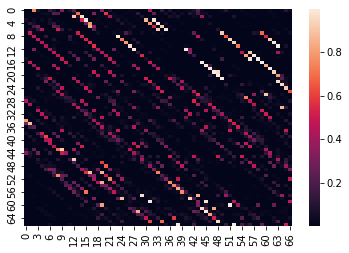

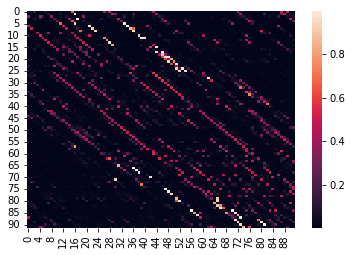

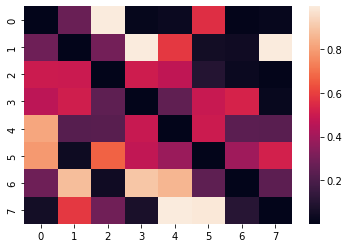

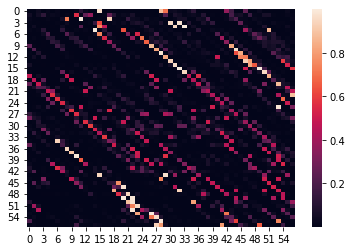

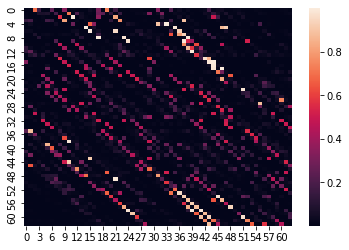

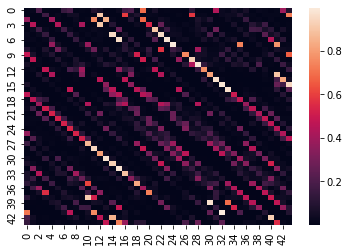

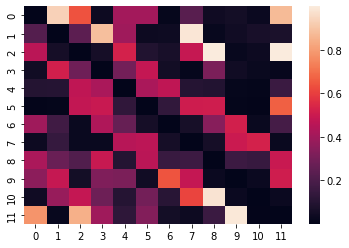

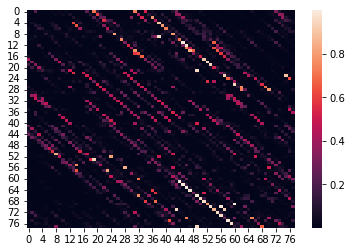

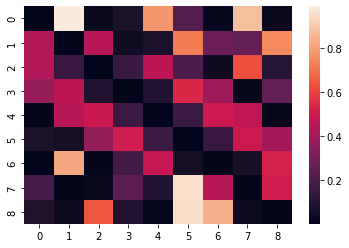

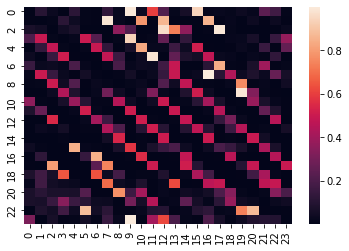

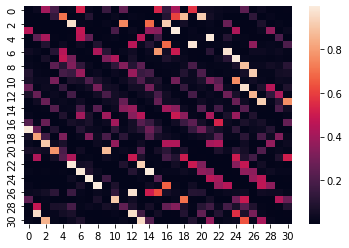

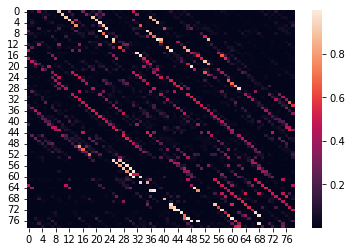

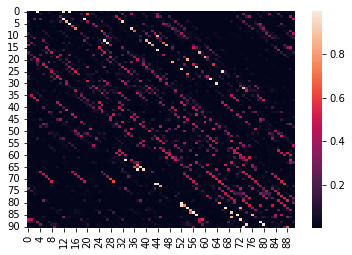

In [114]:
batch = 4

seq_lengths = [len([n for n in m if n != -2])  for m in masks[batch]]
cat_labels = [e[:seq_lengths[idx]] for idx, e in enumerate(categories[batch]) ] 

for i in range(15):
    plot = np.max(attn[batch][i], axis=0) 
    
    # Identify non-zero rows and columns
    non_zero_rows = np.any(plot!= 0, axis=1)  # Rows with any non-zero value
    non_zero_columns = np.any(plot != 0, axis=0)  # Columns with any non-zero value

    # Filter the array
    filtered_array = plot[non_zero_rows][:, non_zero_columns]
    
    sns.heatmap(filtered_array)
    plt.show()
    

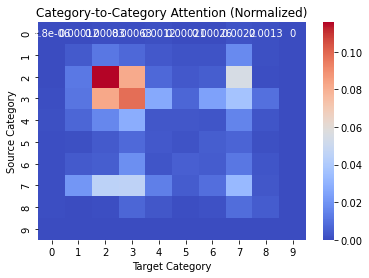

In [104]:
batch = 6  # Example batch number
seq_lengths = [len([n for n in m if n != -2]) for m in masks[batch]]
cat_labels = [e[:seq_lengths[idx]] for idx, e in enumerate(categories[batch])]
num_sequences = 15

# Initialize a category-to-category correlation matrix
num_categories = 10
cat_correl = np.zeros((num_categories, num_categories))

for i in range(num_sequences):
    # Extract and process the attention matrix
    plot = np.max(attn[batch][i], axis=0)  # Take max attention across heads for each token
    
    # Identify non-zero rows and columns
    non_zero_rows = np.any(plot != 0, axis=1)  # Rows with any non-zero value
    non_zero_columns = np.any(plot != 0, axis=0)  # Columns with any non-zero value
    
    # Filter the array to exclude padding
    filtered_array = plot[non_zero_rows][:, non_zero_columns]
    
    # Get the category labels for the non-padded sequence
    labels = cat_labels[i]
    valid_labels = labels[:len(filtered_array)]  # Adjust labels to match filtered_array size
    
    # Create a DataFrame with filtered attention and category labels
    df = pd.DataFrame(filtered_array)
    df.columns = valid_labels
    df.index = valid_labels
    
    # Normalize the attention values row-wise (optional step to avoid bias from highly active categories)
    df = df.div(df.sum(axis=1), axis=0).fillna(0)
    
    # Compute category-to-category attention matrix for this sequence
    seq_cat_correl = np.zeros((num_categories, num_categories))
    for a in range(num_categories):
        for b in range(num_categories):
            # Sum attention weights between categories a and b
            if a in df.columns and b in df.index:
                seq_cat_correl[a, b] = df.loc[df.index == b, df.columns == a].values.sum()
    
    # Normalize the category correlation matrix for the sequence
    if seq_cat_correl.sum() > 0:
        seq_cat_correl /= seq_cat_correl.sum()
    
    # Accumulate normalized sequence contribution
    cat_correl += seq_cat_correl

# Normalize the aggregated category correlation matrix across all sequences
cat_correl /= num_sequences  # Assuming 15 sequences processed


sns.heatmap(pd.DataFrame(cat_correl, index=range(num_categories), columns=range(num_categories)), 
            annot=True, cmap="coolwarm")
plt.title("Category-to-Category Attention (Normalized)")
plt.xlabel("Target Category")
plt.ylabel("Source Category")
plt.show()


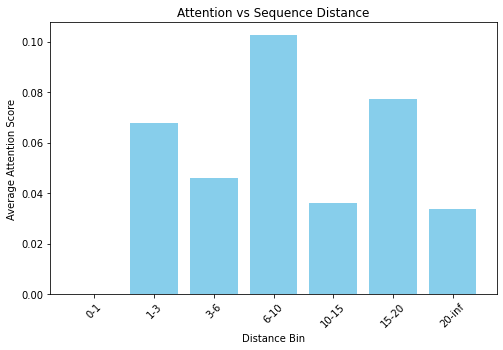

In [110]:
# Initialize binned_attention with actual bin start values as keys
batch = 22  # Example batch number
seq_lengths = [len([n for n in m if n != -2]) for m in masks[batch]]
cat_labels = [e[:seq_lengths[idx]] for idx, e in enumerate(categories[batch])]

distance_bins = [0, 1, 3, 6, 10, 15, 20, np.inf]  # Define distance bins
binned_attention = {d_bin_start: [] for d_bin_start in distance_bins[:-1]}

for i in range(15):
    # Extract and process the attention matrix
    plot = np.max(attn[batch][i], axis=0)  # Take max attention across heads for each token
    
    # Identify non-zero rows and columns
    non_zero_rows = np.any(plot != 0, axis=1)  # Rows with any non-zero value
    non_zero_columns = np.any(plot != 0, axis=0)  # Columns with any non-zero value
    filtered_array = plot[non_zero_rows][:, non_zero_columns]
    
    # Compute pairwise distances
    seq_len = len(filtered_array)
    distances = np.abs(np.arange(seq_len).reshape(-1, 1) - np.arange(seq_len).reshape(1, -1))
    
    # Bin distances and calculate mean attention per bin
    for d_bin_start, d_bin_end in zip(distance_bins[:-1], distance_bins[1:]):
        mask = (distances >= d_bin_start) & (distances < d_bin_end)
        binned_attention[d_bin_start].append(filtered_array[mask].mean() if mask.any() else 0)

# Aggregate results across all sequences
binned_means = {bin_start: np.mean(values) for bin_start, values in binned_attention.items()}

# Visualization
plt.figure(figsize=(8, 5))
bin_labels = [f"{distance_bins[i]}-{distance_bins[i+1]}" for i in range(len(distance_bins) - 1)]
plt.bar(bin_labels, binned_means.values(), color="skyblue")
plt.xlabel("Distance Bin")
plt.ylabel("Average Attention Score")
plt.title("Attention vs Sequence Distance")
plt.xticks(rotation=45)
plt.show()


# after looking at which distance from the diagonal the gene is then break down the categories within these bins to which are having the mosst effect 

<ipython-input-112-8c9c6d3e457d>:35: RuntimeWarning: invalid value encountered in divide
  cat_distance_attention /= np.sum(cat_distance_attention, axis=2, keepdims=True)


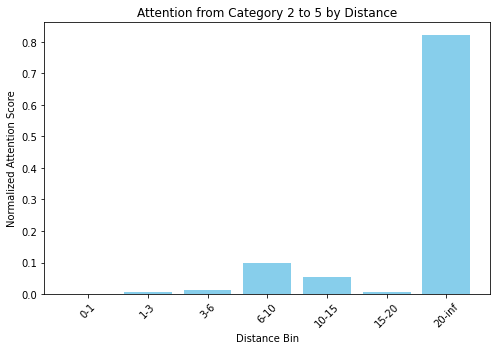

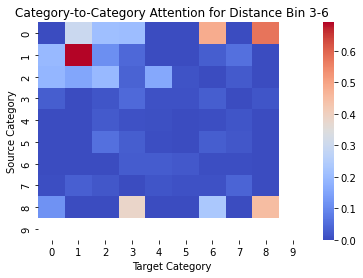

In [112]:
# Initialize the 3D matrix for category-distance attention
num_categories = 10
num_distance_bins = len(distance_bins) - 1
cat_distance_attention = np.zeros((num_categories, num_categories, num_distance_bins))

for i in range(15):
    # Extract and process the attention matrix
    plot = np.max(attn[batch][i], axis=0)  # Take max attention across heads for each token
    
    # Identify non-zero rows and columns
    non_zero_rows = np.any(plot != 0, axis=1)
    non_zero_columns = np.any(plot != 0, axis=0)
    filtered_array = plot[non_zero_rows][:, non_zero_columns]
    
    # Compute pairwise distances
    seq_len = len(filtered_array)
    distances = np.abs(np.arange(seq_len).reshape(-1, 1) - np.arange(seq_len).reshape(1, -1))
    
    # Get category labels for the non-padded sequence
    valid_labels = cat_labels[i][:seq_len]
    
    # Accumulate attention by category and distance
    for d_bin_idx, (d_bin_start, d_bin_end) in enumerate(zip(distance_bins[:-1], distance_bins[1:])):
        mask = (distances >= d_bin_start) & (distances < d_bin_end)
        for src_cat in range(num_categories):
            for tgt_cat in range(num_categories):
                # Filter rows and columns by source and target categories
                src_indices = np.where(np.array(valid_labels) == src_cat)[0]
                tgt_indices = np.where(np.array(valid_labels) == tgt_cat)[0]
                submask = mask[np.ix_(src_indices, tgt_indices)]
                if submask.any():
                    cat_distance_attention[src_cat, tgt_cat, d_bin_idx] += filtered_array[np.ix_(src_indices, tgt_indices)][submask].sum()

# Normalize along the distance axis for each category pair
cat_distance_attention /= np.sum(cat_distance_attention, axis=2, keepdims=True)

# Visualize category-distance attention for a specific category pair
src_category = 2  # Example source category
tgt_category = 5  # Example target category
attention_by_distance = cat_distance_attention[src_category, tgt_category, :]

plt.figure(figsize=(8, 5))
bin_labels = [f"{distance_bins[i]}-{distance_bins[i+1]}" for i in range(num_distance_bins)]
plt.bar(bin_labels, attention_by_distance, color="skyblue")
plt.xlabel("Distance Bin")
plt.ylabel("Normalized Attention Score")
plt.title(f"Attention from Category {src_category} to {tgt_category} by Distance")
plt.xticks(rotation=45)
plt.show()

# Visualize overall category-to-category attention for a specific distance bin
distance_bin_idx = 2  # Example distance bin index
cat_to_cat_attention = cat_distance_attention[:, :, distance_bin_idx]

sns.heatmap(pd.DataFrame(cat_to_cat_attention, index=range(num_categories), columns=range(num_categories)), 
            cmap="coolwarm")
plt.title(f"Category-to-Category Attention for Distance Bin {distance_bins[distance_bin_idx]}-{distance_bins[distance_bin_idx + 1]}")
plt.xlabel("Target Category")
plt.ylabel("Source Category")
plt.show()


In [77]:
scores = np.random.rand(16, 4, 95, 95)
scores = torch.Tensor(scores)

src_key_padding_mask = np.zeros((16,95))
src_key_padding_mask [:, :60] = 1
#src_key_padding_mask = np.ones((16,95))
src_key_padding_mask = torch.Tensor(src_key_padding_mask)

scores = scores.masked_fill(src_key_padding_mask.unsqueeze(1).unsqueeze(2) == 0, float("-inf"))
scores = scores.masked_fill(src_key_padding_mask.unsqueeze(1).unsqueeze(3) == 0, float("-inf"))

In [67]:
attn_weights = F.softmax(scores, dim=-1)
#attn_weights.masked_fill(src_key_padding_mask.unsqueeze(1).unsqueeze(2) == 0, 0.0)
#attn_weights

# Mask the resulting attention weights to ensure padded positions have zero attention
#if src_key_padding_mask is not None:
#    attn_weights = attn_weights.masked_fill(src_key_padding_mask.unsqueeze(1).unsqueeze(2) == 0, 0.0)

#attn_weights.fill_(None, 0)

In [68]:
if src_key_padding_mask is not None:
    # Mask out attention weights corresponding to padding positions
    attn_weights = attn_weights.masked_fill(src_key_padding_mask.unsqueeze(1).unsqueeze(2) == 0, 0.0)

    # Renormalize to ensure the weights sum to 1
    #attn_weights = attn_weights / (attn_weights.sum(dim=-1, keepdim=True) + 1e-9)


In [81]:
#attn_weights

In [82]:
torch.nan_to_num(attn_weights, nan=0.0)

tensor([[[[0.0253, 0.0168, 0.0159,  ..., 0.0000, 0.0000, 0.0000],
          [0.0133, 0.0098, 0.0137,  ..., 0.0000, 0.0000, 0.0000],
          [0.0190, 0.0234, 0.0258,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0192, 0.0122, 0.0186,  ..., 0.0000, 0.0000, 0.0000],
          [0.0231, 0.0123, 0.0176,  ..., 0.0000, 0.0000, 0.0000],
          [0.0159, 0.0239, 0.0182,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0233, 0.0223, 0.0141,  ..., 0.0000, 0.0000, 0.0000],
          [0.0249, 0.0149, 0.0131,  ..., 0.0000, 0.0000, 0.0000],
          [0.0142, 0.0103, 0.0251,  ..., 0

In [19]:
attn_weights = F.softmax(scores, dim=-1)
attn_weights.masked_fill(src_key_padding_mask.unsqueeze(1).unsqueeze(2) == 0, 0.0)

tensor([[[[0.0249, 0.0107, 0.0214,  ..., 0.0000, 0.0000, 0.0000],
          [0.0144, 0.0133, 0.0238,  ..., 0.0000, 0.0000, 0.0000],
          [0.0175, 0.0175, 0.0149,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [   nan,    nan,    nan,  ..., 0.0000, 0.0000, 0.0000],
          [   nan,    nan,    nan,  ..., 0.0000, 0.0000, 0.0000],
          [   nan,    nan,    nan,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0182, 0.0230, 0.0144,  ..., 0.0000, 0.0000, 0.0000],
          [0.0118, 0.0102, 0.0159,  ..., 0.0000, 0.0000, 0.0000],
          [0.0212, 0.0170, 0.0162,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [   nan,    nan,    nan,  ..., 0.0000, 0.0000, 0.0000],
          [   nan,    nan,    nan,  ..., 0.0000, 0.0000, 0.0000],
          [   nan,    nan,    nan,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0148, 0.0158, 0.0167,  ..., 0.0000, 0.0000, 0.0000],
          [0.0256, 0.0220, 0.0139,  ..., 0.0000, 0.0000, 0.0000],
          [0.0246, 0.0158, 0.0119,  ..., 0

In [316]:
seq_len=95 # is this 6- or 90 
diag_mask =  torch.eye(seq_len).unsqueeze(0).unsqueeze(0) 
valid_mask = src_key_padding_mask.unsqueeze(1).unsqueeze(2).expand(-1, 4, 95, -1)

In [317]:
#scores

In [318]:
 # Apply the valid mask to the attention weights
attn_weights = scores * valid_mask

# Extract diagonal attention weights
diag_values = attn_weights * diag_mask  # Retain only diagonal values
#diag_values

In [319]:
valid_lengths = src_key_padding_mask.sum(dim=1).unsqueeze(1).unsqueeze(2).expand(-1, 4, 95)

In [327]:
valid_lengths = src_key_padding_mask.sum(dim=1).unsqueeze(1).unsqueeze(2).expand(-1, 4, 95) 
penalty = torch.nansum(diag_values, dim=(-2,-1))/valid_lengths.sum(dim=-1)

In [328]:
penalty.shape

torch.Size([16, 4])

In [326]:
valid_lengths.shape.sum(dim=-1)

AttributeError: 'torch.Size' object has no attribute 'sum'

In [266]:
penalty.shape

torch.Size([16, 4])

In [251]:
diag_values.shape

torch.Size([16, 4, 95, 95])

In [234]:
torch.count_nonzero(diag_values[~diag_values.isnan()])

tensor(3840)

In [233]:
diag_values[~diag_values.isnan()]

tensor([0.1925, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.3494])

In [229]:
valid_lengths = src_key_padding_mask.sum(dim=1).unsqueeze(1).unsqueeze(2).expand(-1, 4, 95) 
penalty = diag_values.sum(dim=(-2, -1))  / valid_lengths.sum(dim=-1) 

penalty

tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]])

In [201]:
diag_values = scores * diag_mask
diag_values

tensor([[[[0.1925, 0.0000, 0.0000,  ...,    nan,    nan,    nan],
          [0.0000, 0.6523, 0.0000,  ...,    nan,    nan,    nan],
          [0.0000, 0.0000, 0.3741,  ...,    nan,    nan,    nan],
          ...,
          [   nan,    nan,    nan,  ...,   -inf,    nan,    nan],
          [   nan,    nan,    nan,  ...,    nan,   -inf,    nan],
          [   nan,    nan,    nan,  ...,    nan,    nan,   -inf]],

         [[0.9402, 0.0000, 0.0000,  ...,    nan,    nan,    nan],
          [0.0000, 0.2177, 0.0000,  ...,    nan,    nan,    nan],
          [0.0000, 0.0000, 0.0284,  ...,    nan,    nan,    nan],
          ...,
          [   nan,    nan,    nan,  ...,   -inf,    nan,    nan],
          [   nan,    nan,    nan,  ...,    nan,   -inf,    nan],
          [   nan,    nan,    nan,  ...,    nan,    nan,   -inf]],

         [[0.9020, 0.0000, 0.0000,  ...,    nan,    nan,    nan],
          [0.0000, 0.5459, 0.0000,  ...,    nan,    nan,    nan],
          [0.0000, 0.0000, 0.6984,  ...,  

tensor([[[[0.1925, 0.9631, 0.8049,  ...,    nan,    nan,    nan],
          [0.4783, 0.6523, 0.4226,  ...,    nan,    nan,    nan],
          [0.5496, 0.6435, 0.3741,  ...,    nan,    nan,    nan],
          ...,
          [  -inf,   -inf,   -inf,  ...,    nan,    nan,    nan],
          [  -inf,   -inf,   -inf,  ...,    nan,    nan,    nan],
          [  -inf,   -inf,   -inf,  ...,    nan,    nan,    nan]],

         [[0.9402, 0.3478, 0.6447,  ...,    nan,    nan,    nan],
          [0.8361, 0.2177, 0.3493,  ...,    nan,    nan,    nan],
          [0.6131, 0.8348, 0.0284,  ...,    nan,    nan,    nan],
          ...,
          [  -inf,   -inf,   -inf,  ...,    nan,    nan,    nan],
          [  -inf,   -inf,   -inf,  ...,    nan,    nan,    nan],
          [  -inf,   -inf,   -inf,  ...,    nan,    nan,    nan]],

         [[0.9020, 0.2937, 0.7207,  ...,    nan,    nan,    nan],
          [0.6699, 0.5459, 0.2350,  ...,    nan,    nan,    nan],
          [0.3425, 0.2323, 0.6984,  ...,  

In [ ]:
# this seems to be working now. Scale to the entire PhageScope dataset and see what happens 

In [33]:
# maybe this incorrect is due to the batch size 

0


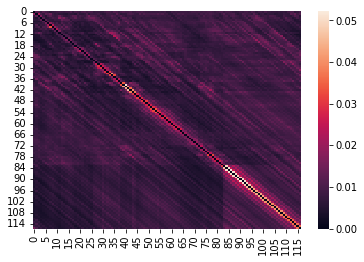

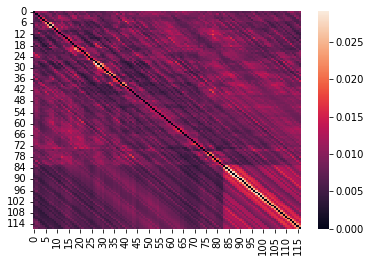

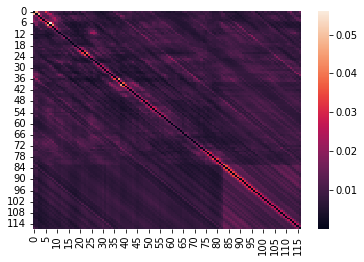

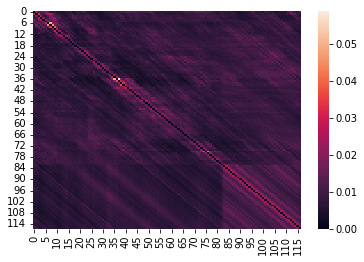

1


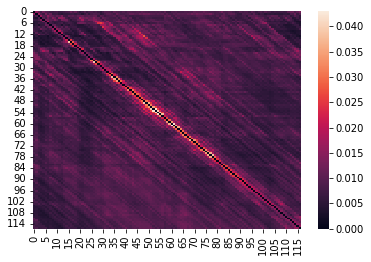

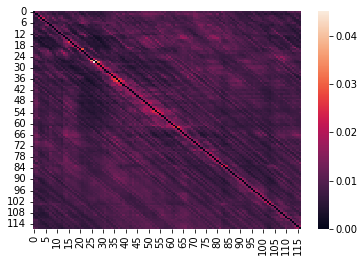

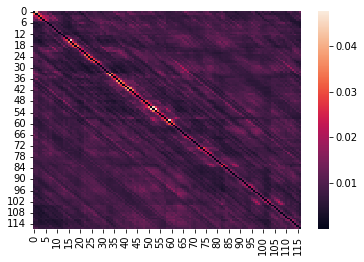

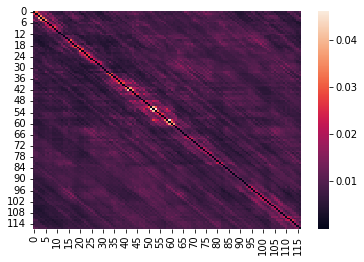

2


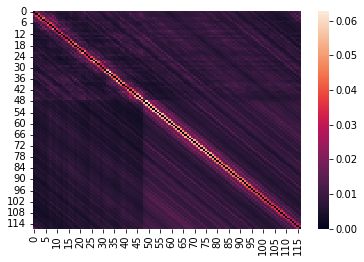

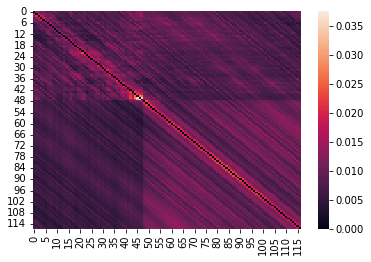

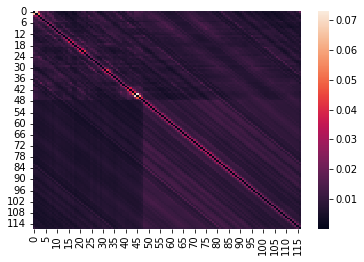

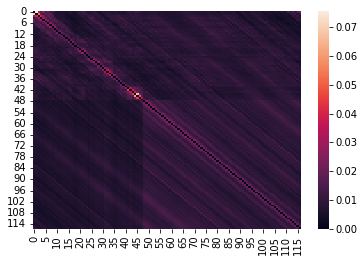

3


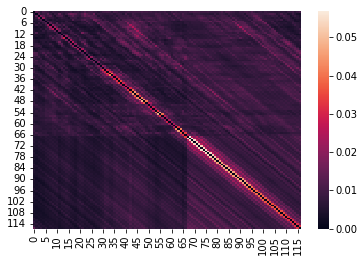

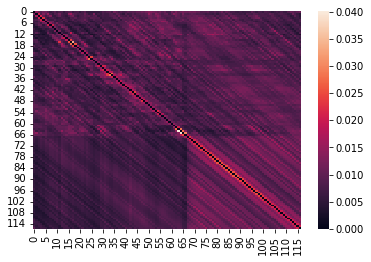

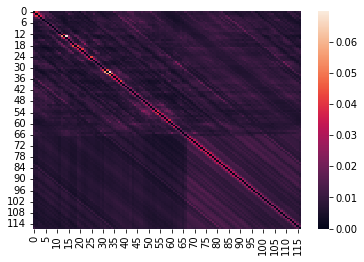

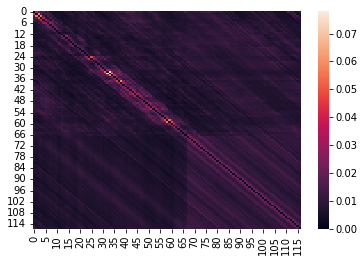

4


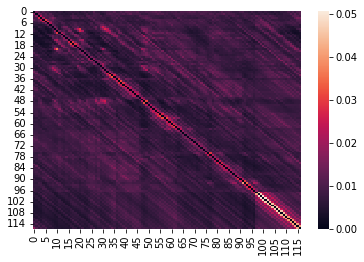

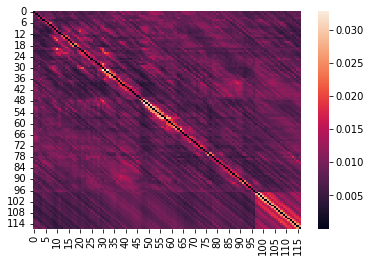

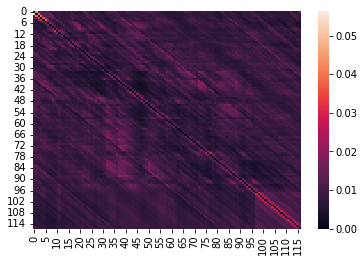

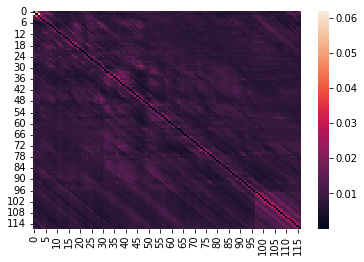

5


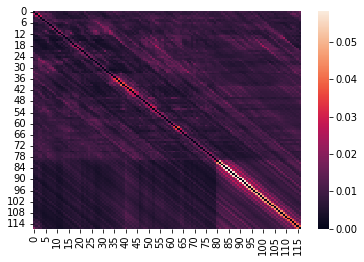

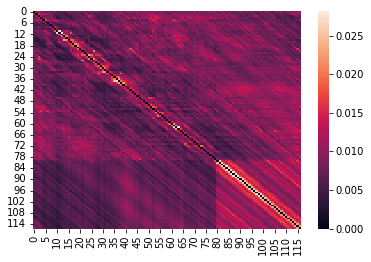

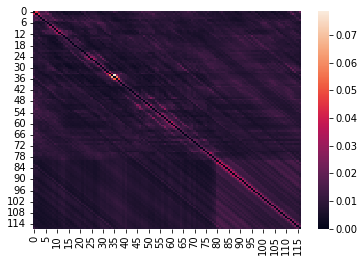

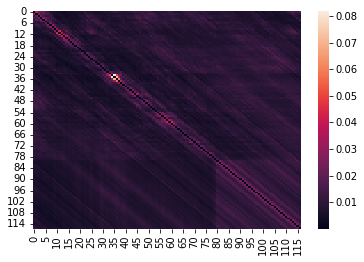

6


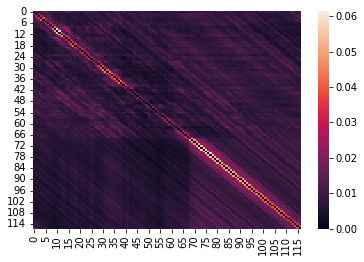

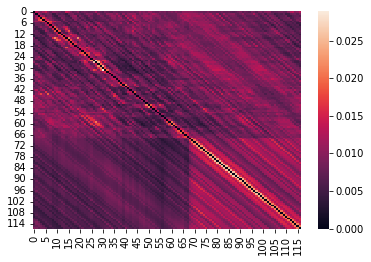

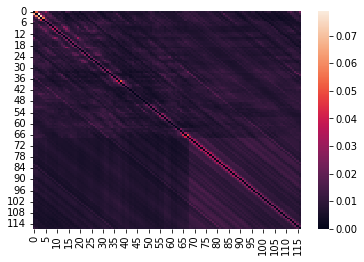

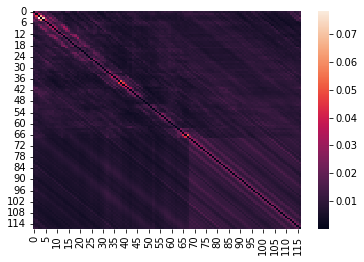

7


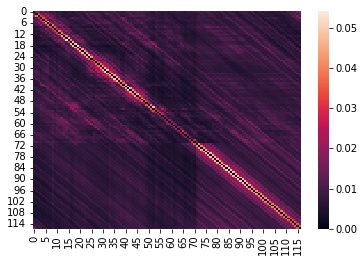

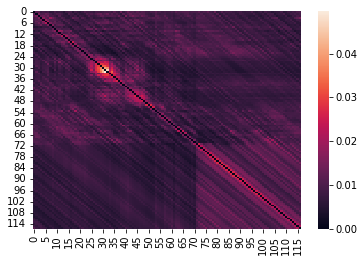

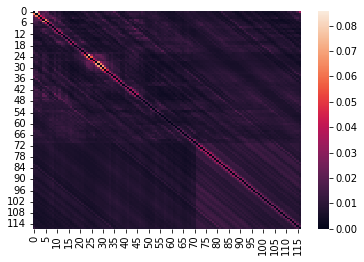

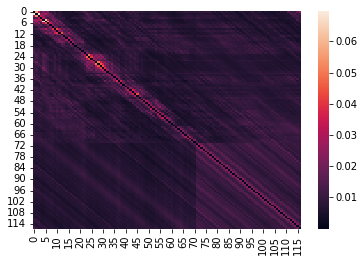

8


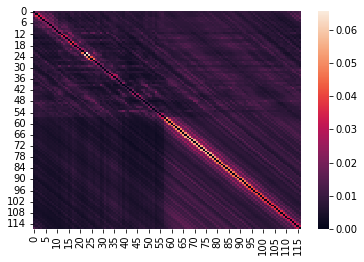

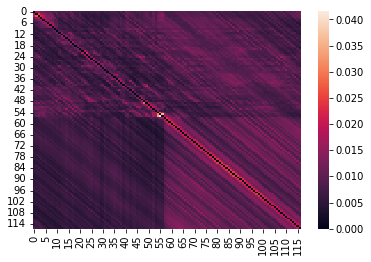

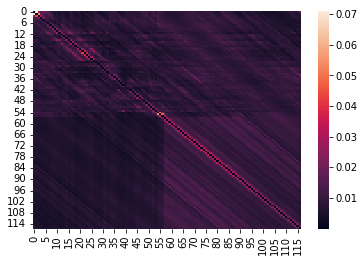

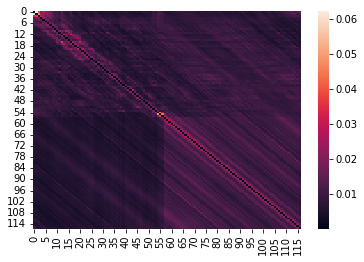

9


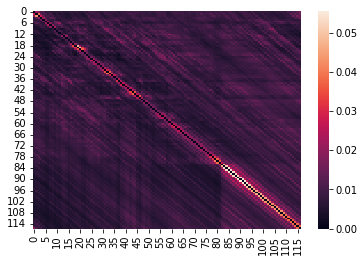

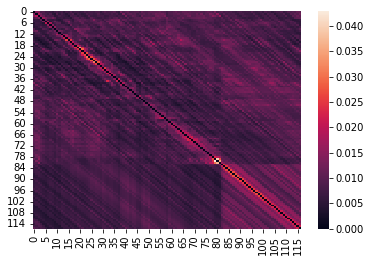

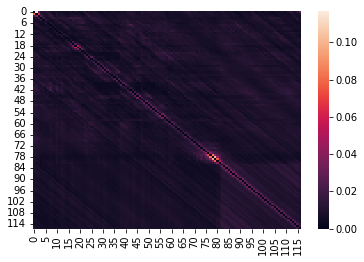

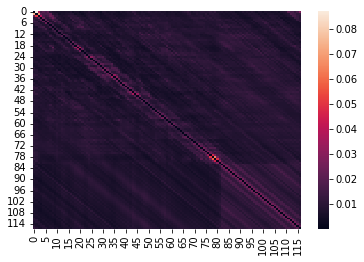

10


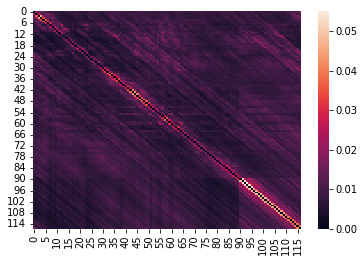

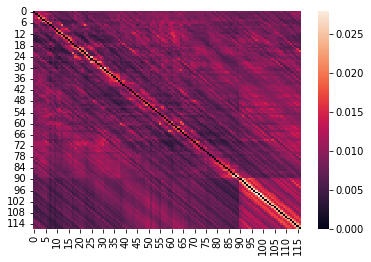

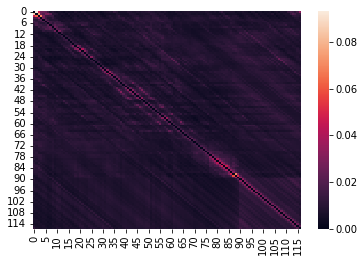

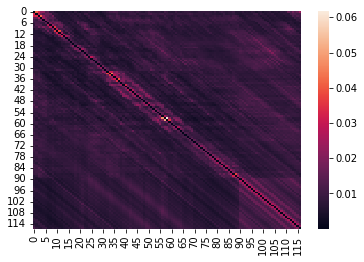

11


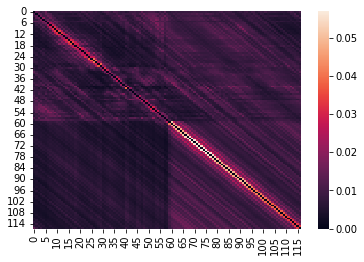

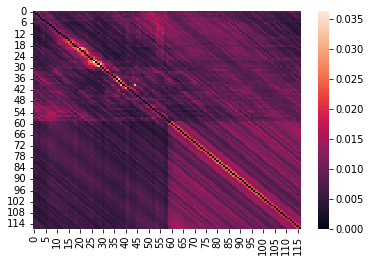

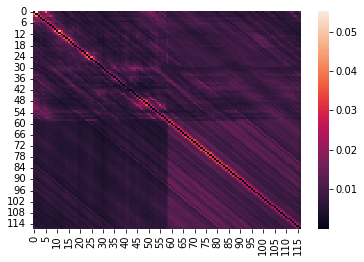

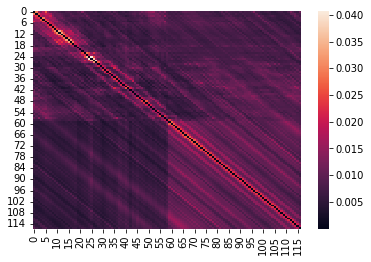

12


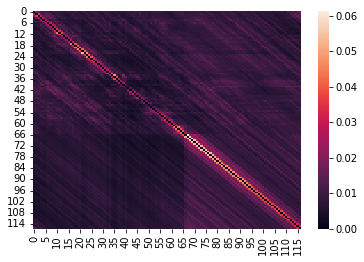

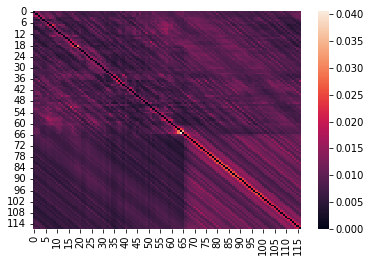

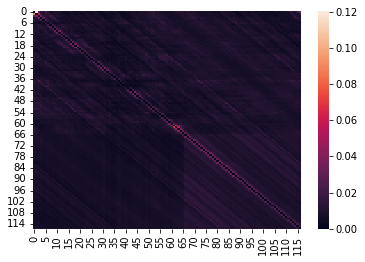

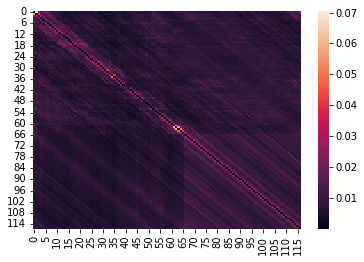

13


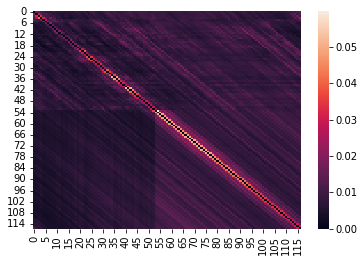

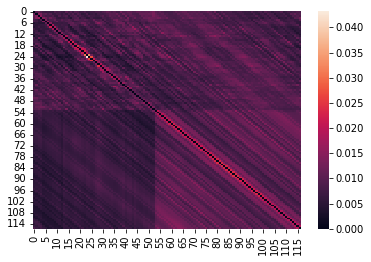

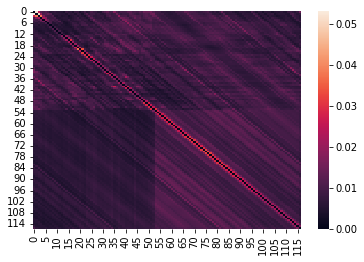

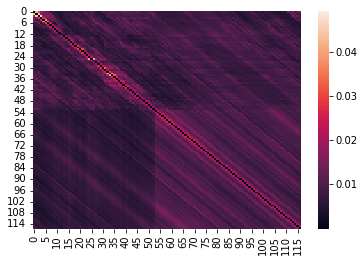

14


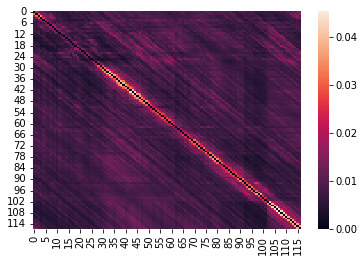

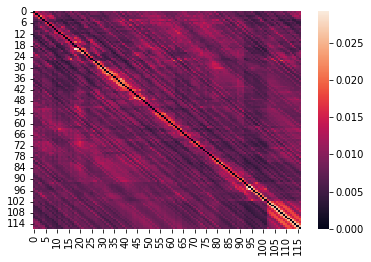

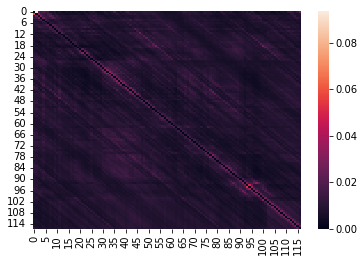

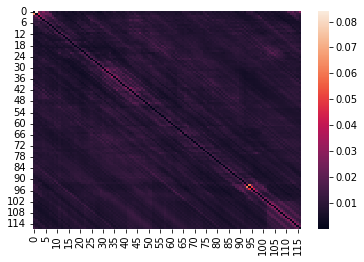

15


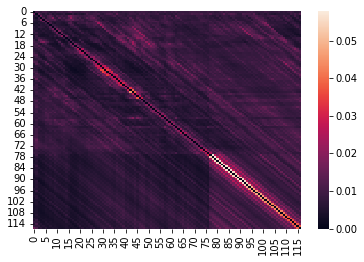

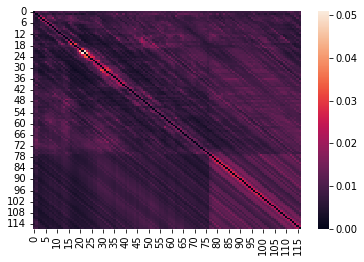

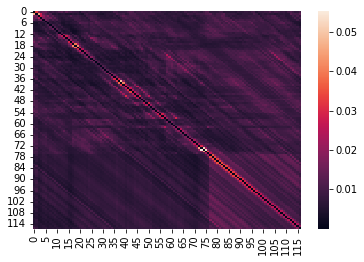

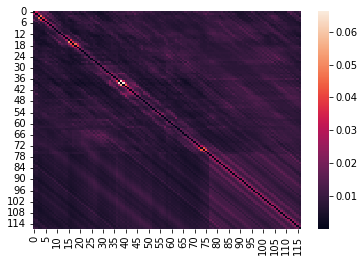

16


IndexError: index 16 is out of bounds for axis 0 with size 16

In [34]:
for i in range(50): 
    print(i)
    sns.heatmap(attn[1][i][0])
    plt.show()
    sns.heatmap(attn[1][i][1])
    plt.show()
    sns.heatmap(attn[1][i][2])
    plt.show()
    sns.heatmap(attn[1][i][3])
    plt.show()



#sns.heatmap(attn[0][5][1])

<AxesSubplot:>

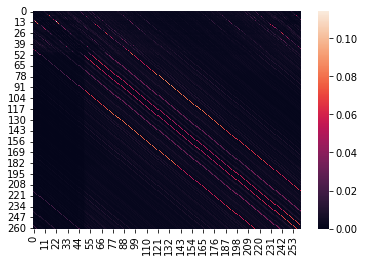

In [35]:
sns.heatmap(attn[0][20][1])

In [99]:
attn[0].shape

(16, 4, 138, 138)

In [101]:
attn[0].shape

(16, 4, 138, 138)

In [ ]:
# weird squiggle at the start is probably becuase of the learning rate warmup 

In [30]:
m_d05 = pd.read_csv('0.3_circular_1e-4_0.05_256_4_2_16_0.05_metrics.csv')
m_d1 = pd.read_csv('0.3_circular_1e-4_0.1_256_4_2_16_0.05_metrics.csv')

<AxesSubplot:xlabel='epoch', ylabel='training losses'>

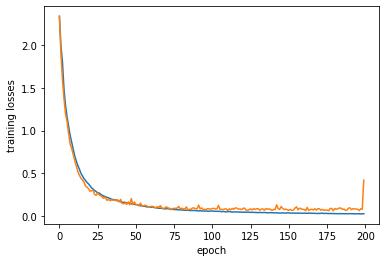

In [31]:
sns.lineplot(data=m_d05, x = 'epoch', y = 'training losses') 
sns.lineplot(data=m_d05, x = 'epoch', y = 'validation losses') 

<AxesSubplot:xlabel='epoch', ylabel='training losses'>

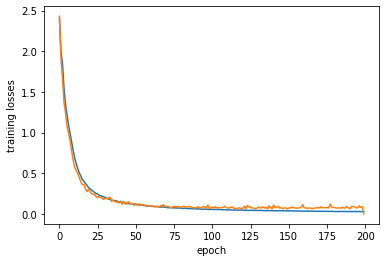

In [32]:
sns.lineplot(data=m_d1, x = 'epoch', y = 'training losses') 
sns.lineplot(data=m_d1, x = 'epoch', y = 'validation losses') 

In [33]:
m_d1

epoch  training losses  validation losses
0        0         2.407285           2.430552
1        1         1.994908           1.912884
2        2         1.850038           1.669332
3        3         1.545093           1.370974
4        4         1.344181           1.241037
..     ...              ...                ...
195    195         0.029689           0.077198
196    196         0.029115           0.099979
197    197         0.028252           0.082712
198    198         0.027624           0.086140
199    199         0.027431           0.000265

[200 rows x 3 columns]

In [34]:
m_d05

epoch  training losses  validation losses
0        0         2.340175           2.336944
1        1         1.987211           1.896459
2        2         1.800871           1.594293
3        3         1.480132           1.370963
4        4         1.294936           1.195050
..     ...              ...                ...
195    195         0.025392           0.078199
196    196         0.025416           0.063337
197    197         0.023703           0.084298
198    198         0.024497           0.077255
199    199         0.026222           0.419072

[200 rows x 3 columns]

## import pickle

In [4]:
val = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer/notebooks/January2024/val_kfold_loader.pkl', 'rb'))

m = model_onehot.Seq2SeqTransformerClassifierCircularRelativeAttention(input_dim=1293, num_classes=9, num_heads=8, hidden_dim=256, dropout=0.1)
m.load_state_dict(torch.load('/home/grig0076/GitHubs/Phynteny_transformer/notebooks/January2024/checkpoint_epoch_1.pt', map_location=torch.device('cpu'))
                 )
m.eval()

# are now able to successfully read in model files 
#- wait until another new model has completed training then start to see if I can get attention weights etc to line up 

Seq2SeqTransformerClassifierCircularRelativeAttention(
  (func_embedding): Embedding(10, 16)
  (strand_embedding): Embedding(2, 4)
  (length_embedding): Linear(in_features=1, out_features=8, bias=True)
  (embedding_layer): Linear(in_features=1280, out_features=228, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): CircularTransformerEncoderLayer(
        (self_attn): CircularRelativePositionAttention()
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
  

In [141]:
for embeddings, categories, masks, idx in val:
    break

In [146]:
m(embeddings[:62]).shape # this means that a prediction can be made with a batch smaller than the largest possible 

torch.Size([62, 200, 9])

In [148]:
m(embeddings[:62])

torch.Size([62, 200, 9])

In [152]:
masks.shape

torch.Size([64, 200])

In [158]:
masks[4]

tensor([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  1.,  0., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -

In [159]:
categories[4]

tensor([-1, -1, -1, -1,  3, -1, -1,  2, -1, -1, -1, -1, -1,  2,  7, -1,  1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1])

In [160]:
idx[4] # i feel like this isn't how masking should happen

tensor([4])

In [168]:
embeddings[0][6][:10]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=torch.float64)

### Visualise the embeddings produced using a UMAP 
Ideally the phynteny embeddings will show greater separation between the classes than the raw ESM2 embeddings 

In [50]:
embedding_only = pd.DataFrame(embeddings[:, :, 13:][masks != -2])
categories_only = categories[masks != -2]

In [52]:
# Initialize the UMAP reducer
reducer = umap.UMAP(random_state=42)

# Fit and transform the data
umap_results = reducer.fit_transform(embedding_only)

/home/grig0076/miniconda3/envs/notebook_env/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


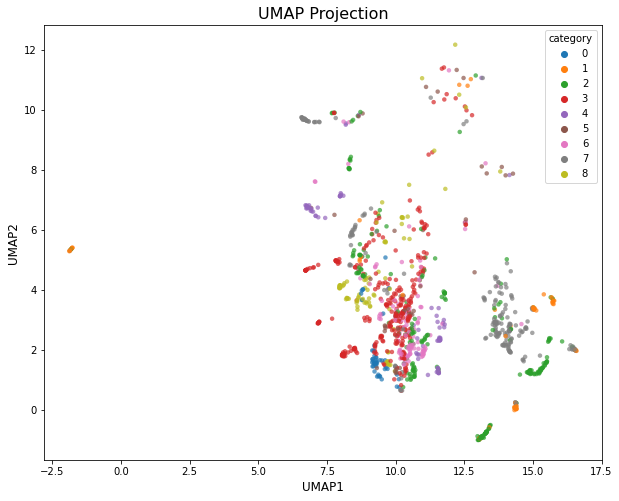

In [74]:
# Convert the results into a DataFrame for easy handling
umap_df = pd.DataFrame(umap_results, columns=['UMAP1', 'UMAP2'])
umap_df['category'] = categories_only.numpy()

# Plot the UMAP results
plt.figure(figsize=(10, 8))
sns.scatterplot(data = umap_df[umap_df['category'] != -1], x = 'UMAP1', y='UMAP2', s=20, alpha=0.7, hue = 'category', palette='tab10',linewidth=0)
plt.title('UMAP Projection', fontsize=16)
plt.xlabel('UMAP1', fontsize=12)
plt.ylabel('UMAP2', fontsize=12)
plt.show()

In [ ]:
slightly dodgy for now because some of these are not masked from the model 
- remake later with just the masked ones 

In [170]:
# compare with the Phynteny attention weights
val_weights = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer/notebooks/January2024/final_validation_weights.pkl', 'rb'))
val_categories = pickle.load(open('/home/grig0076/GitHubs/Phynteny_transformer/notebooks/January2024/final_validation_categories.pkl', 'rb'))

In [175]:
val_weights[0].shape

(64, 236, 128)

In [103]:
for idx, p  in enumerate(val_weights): 
    p[val_categories[idx][0] != -1]
    break

IndexError: boolean index did not match indexed array along dimension 0; dimension is 64 but corresponding boolean dimension is 261

In [138]:
pd.DataFrame(p[2])[val_categories[idx][2] != -1]

0         1         2         3         4         5         6  \
11 -4.433594 -4.585938  7.359375 -3.607422 -4.074219 -3.914062 -3.548828   
13 -4.082031 -4.402344  7.492188 -3.150391 -3.613281 -3.699219 -3.474609   
29 -8.976562 -6.140625 -5.656250  5.617188 -5.863281 -3.611328 -1.966797   
35 -5.894531 -5.324219 -4.378906 -1.561523 -4.316406 -3.076172  6.234375   

           7         8  
11 -3.226562 -4.058594  
13 -3.601562 -4.078125  
29 -5.613281 -6.355469  
35 -4.488281 -5.000000

In [139]:
val_categories[idx][2] [val_categories[idx][2] != -1] # we can see that the largest number seems to be matching up 

array([2, 2, 3, 6])

In [ ]:
# does this output dimension actually need to be 10 or could it be higher???  
# just get these here for the masked datapoints - then go and plot 

In [132]:
val_categories[idx][0] != -1

array([False, False,  True, False, False, False, False,  True,  True,
       False, False, False,  True, False, False, False, False,  True,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [106]:
val_categories

# the weights are just the 10 softmax so don't know if that is helpful

[array([[-1, -1,  3, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]]),
 array([[-1,  3,  2, ..., -1, -1, -1],
        [ 4, -1,  4, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1,  6, -1, ..., -1, -1, -1],
        [-1,  8, -1, ..., -1, -1, -1]]),
 array([[-1, -1,  3, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [ 0,  0, -1, ..., -1, -1, -1],
        ...,
        [-1,  7,  7, ..., -1, -1, -1],
        [ 0, -1, -1, ..., -1, -1, -1],
        [-1,  7, -1, ..., -1, -1, -1]]),
 array([[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1,  2,  3, ..., -1, -1, -1],
        ...,
        [ 3, -1,  3, ..., -1, -1, -1],
        [-1,  0, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]]),
 arr

In [102]:
val_categories[idx][0] != -1

array([False, False,  True, False, False, False, False,  True,  True,
       False, False, False,  True, False, False, False, False,  True,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,